In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import os
import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier as  dtc
from sklearn.tree import DecisionTreeRegressor as  dtr
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingClassifier as BC
from sklearn.ensemble import GradientBoostingRegressor as BR



#DataSet and Preprocessing

In [55]:
data = pd.read_csv('CarSeats.csv')
data.head()
data['Sales'] = data.Sales.map(lambda x: "high" if x > np.mean(data.Sales) else "Low").astype('category')
#print(data.head())
data.Urban.unique()
data.US.unique()
#data.ShelveLoc = pd.factorize(data.ShelveLoc)[0]
data.ShelveLoc = data.ShelveLoc.map({"Good": 3, "Medium": 2, "Bad" : 1}).astype('category')
data = pd.get_dummies(data, columns=['Urban', 'US'], drop_first=True).astype('category')

data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban_Yes,US_Yes
0,high,138,73,11,276,120,1,42,17,True,True
1,high,111,48,16,260,83,3,65,10,True,True
2,high,113,35,10,269,80,2,59,12,True,True
3,Low,117,100,4,466,97,2,55,14,True,True
4,Low,141,64,3,340,128,1,38,13,True,False


In [56]:
#traing and testing
x= data.drop(['Sales'], axis=1)
y = data.Sales

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=8)
print(x_train.shape)
print(x_test.shape) #testing
print(y_train.shape)
print(y_test.shape)


(320, 10)
(80, 10)
(320,)
(80,)


CLASSIFICATION DECISION TREES

1.0
Test: 0.8375
Number of leaves 53
['Low', 'high']
Categories (2, object): ['Low', 'high']


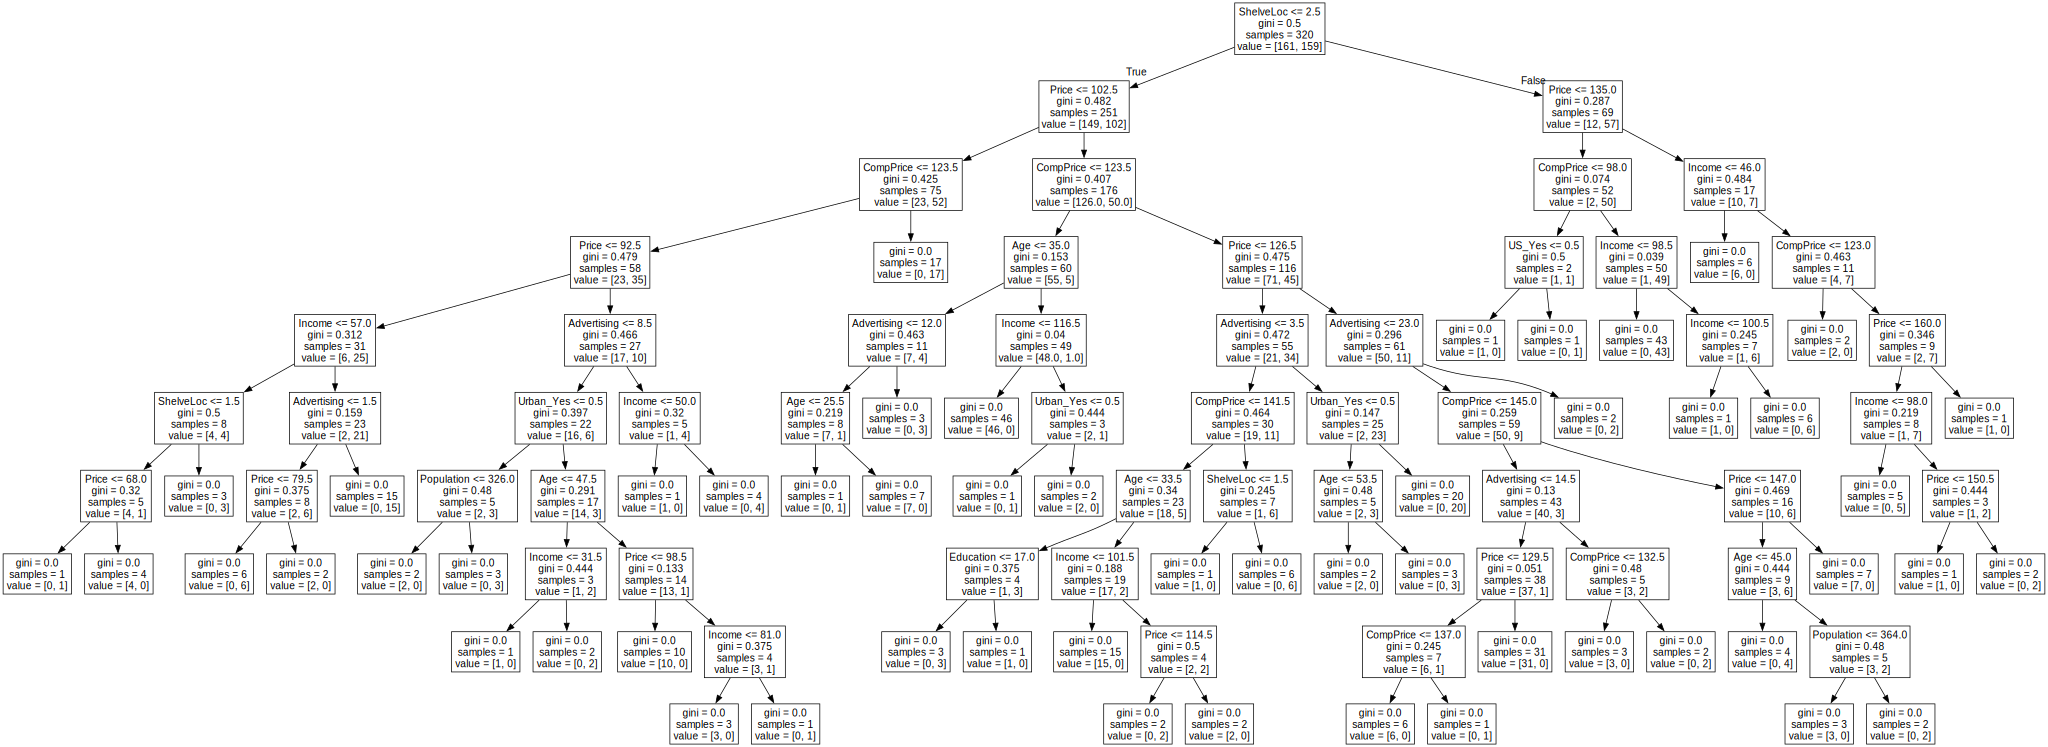

In [57]:
#classifier provided with hyperparameters
classifier = dtc()
classifier.fit(x_train, y_train)
#calculate for training accuracy
print(classifier.score(x_train, y_train))
print(f"Test: {classifier.score(x_test, y_test)}")
print(f"Number of leaves {classifier.tree_.n_leaves}")
print(y_train.unique())

export_graphviz(classifier,out_file='classifier.dot', feature_names=x.columns)
with open('classifier.txt') as f:
    dt_graph = f.read()

os.environ["PATH"] += os.pathsep + "C:\\Users\\juliu\\Graphviz-12.2.1-win64\\bin"
graphviz.Source(dt_graph)


PRUNNING

[0.         0.00273437 0.00290179 0.00300481 0.00304276 0.00306122
 0.00416667 0.00425347 0.0046875  0.005      0.005      0.00535714
 0.00546875 0.00547094 0.00559211 0.00567817 0.00570652 0.00575
 0.00591578 0.00618687 0.00625    0.00691445 0.00707912 0.00852732
 0.00858481 0.00880353 0.0098262  0.013728   0.01503644 0.024202
 0.0260947  0.02879347 0.055048   0.05958769]
[0.85, 0.8625, 0.8375, 0.85, 0.875, 0.8625, 0.8375, 0.8625, 0.8375, 0.85, 0.8625, 0.85, 0.8375, 0.8625, 0.8625, 0.8625, 0.875, 0.8625, 0.85, 0.8625, 0.8625, 0.85, 0.8625, 0.825, 0.825, 0.825, 0.825, 0.8125, 0.7875, 0.7875, 0.7375, 0.75, 0.675, 0.5]


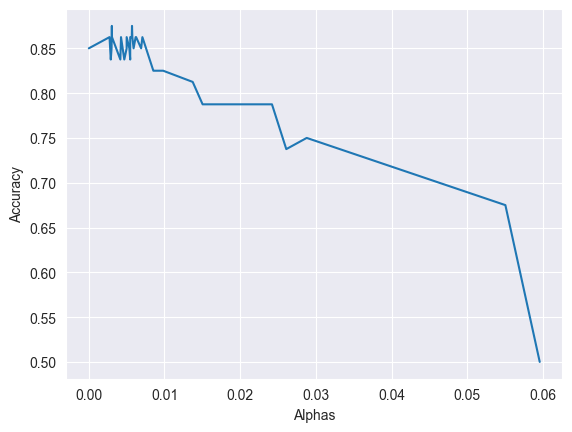

4
0.003042763157894734


In [58]:
path = classifier.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas
print(ccp_alphas)
accuracy_list = []
for a in ccp_alphas:
    clf = dtc(ccp_alpha=a)
    clf.fit(x_train, y_train)
    y_predicts = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_predicts)
    accuracy_list.append(accuracy)
print(accuracy_list)
plt.plot(ccp_alphas, accuracy_list)
plt.xlabel("Alphas")
plt.ylabel("Accuracy")
plt.show()

best_alpha_index = accuracy_list.index(max(accuracy_list))
print(best_alpha_index)
print(ccp_alphas[best_alpha_index])


0.984375
Test: 0.825
Number of leaves 43
['Low', 'high']
Categories (2, object): ['Low', 'high']


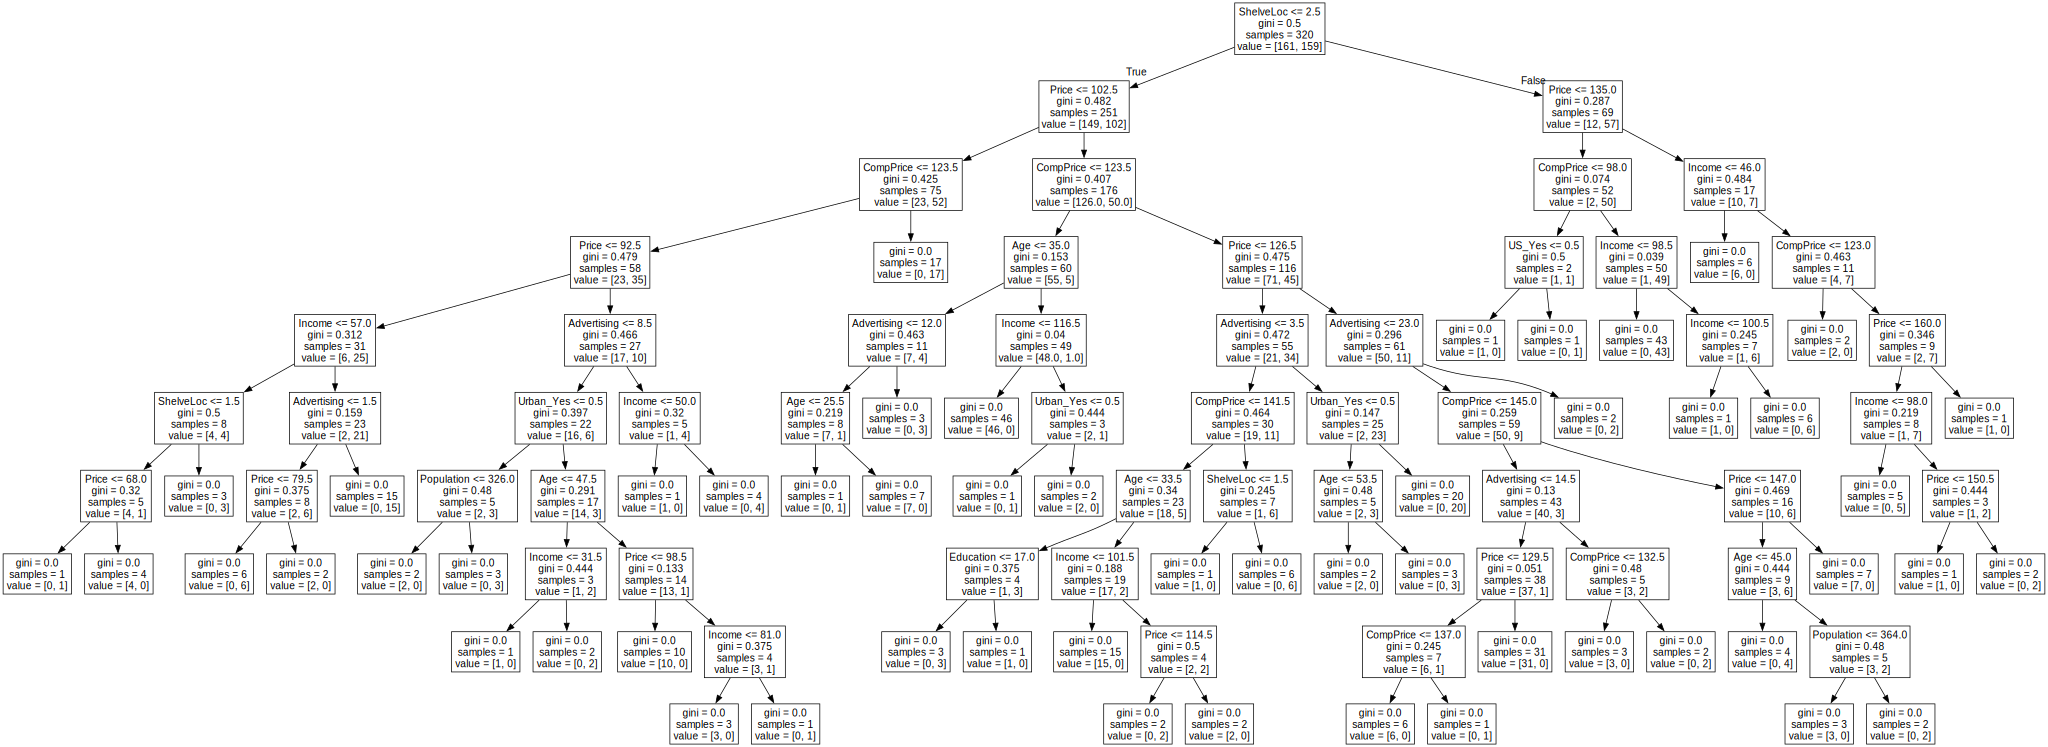

In [59]:
#classifier provided with hyperparameters
classifier1 = dtc(ccp_alpha=ccp_alphas[best_alpha_index])
classifier1.fit(x_train, y_train)
#calculate for training accuracy
print(classifier1.score(x_train, y_train))
print(f"Test: {classifier1.score(x_test, y_test)}")
print(f"Number of leaves {classifier1.tree_.n_leaves}")
print(y_train.unique())

export_graphviz(classifier1,out_file='classifier.dot', feature_names=x.columns)
with open('classifier.txt') as f:
    dt_graph = f.read()

os.environ["PATH"] += os.pathsep + "C:\\Users\\juliu\\Graphviz-12.2.1-win64\\bin"
graphviz.Source(dt_graph)

Bagging and Random Forest


In [60]:
#Bagging
print(len(x_train.columns)) #research whether to use x or x_train
bagging_model = RFC(max_features=len(x.columns), n_estimators=20, random_state=42) #
y_predict= bagging_model.fit(x_train, y_train).predict(x_test)
acc = accuracy_score(y_test, y_predict)
print("Predict accuracy", acc)
#---ToDO: Investigate why more estimators causes error in bagging

10
Predict accuracy 0.8375


In [61]:
#RANDOM FOREST
print(len(x_train.columns)) #research whether to use x or x_train
random_model = RFC(max_features=int(np.sqrt(len(x.columns))), n_estimators=20, random_state=42) #
y_predict= random_model.fit(x_train, y_train).predict(x_test)
acc = accuracy_score(y_test, y_predict)
print("Predict accuracy", acc)

10
Predict accuracy 0.8


Test different number of estimators

N-estimator 20
Predict accuracy 0.8
N-estimator 30
Predict accuracy 0.7875
N-estimator 40
Predict accuracy 0.7875
N-estimator 50
Predict accuracy 0.8125
N-estimator 60
Predict accuracy 0.8
N-estimator 70
Predict accuracy 0.8
N-estimator 80
Predict accuracy 0.8
N-estimator 90
Predict accuracy 0.8125
N-estimator 100
Predict accuracy 0.8
N-estimator 110
Predict accuracy 0.7875
Urban_Yes       0.507890
US_Yes          1.229424
Education       2.587031
Population      4.548303
Income          8.021507
Advertising    10.869238
Age            11.678046
CompPrice      14.659638
ShelveLoc      15.088701
Price          30.810221
dtype: float64


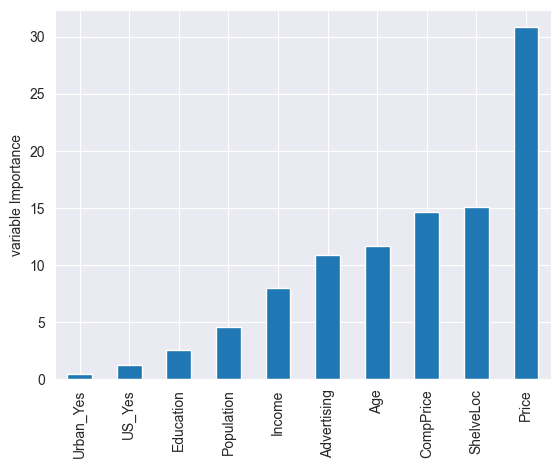

In [73]:
for i in range (20, 111, 10):
    random_model = RFC(max_features=int(np.sqrt(len(x.columns))), n_estimators=i, random_state=42) #
    y_predict= random_model.fit(x_train, y_train).predict(x_test)
    acc = accuracy_score(y_test, y_predict)
    print("N-estimator", i)
    print("Predict accuracy", acc)

#Feature Importance
feature_importance = bagging_model.feature_importances_ *100
feature =pd.Series(feature_importance, index=x.columns).sort_values()
print(feature)
feature.plot(kind="bar")
plt.ylabel("variable Importance")
plt.show()


US_Yes          1.505758
Urban_Yes       1.546481
Education       5.062837
Population      7.939518
Advertising    10.114707
Income         10.171492
CompPrice      12.192379
ShelveLoc      12.517927
Age            12.617735
Price          26.331166
dtype: float64


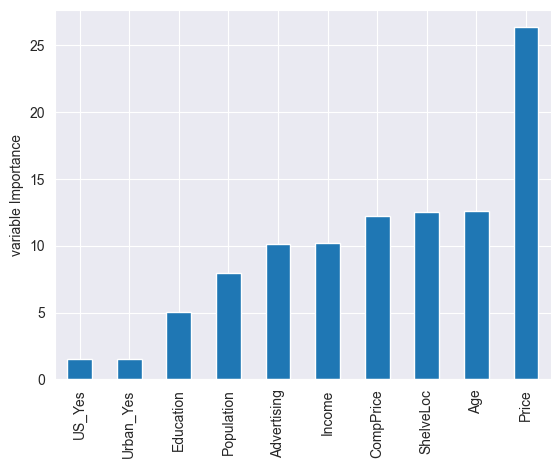

In [72]:
#Random Forest
feature_importance_R= random_model.feature_importances_ *100
feature_R =pd.Series(feature_importance_R, index=x.columns).sort_values()
print(feature_R)
feature_R.T.plot(kind="bar")
plt.ylabel("variable Importance")
plt.show()

Predict accuracy 0.8625
US_Yes          0.000000
Urban_Yes       0.000000
Education       0.000868
Population      0.544231
Income          6.154292
Age             8.406549
Advertising    10.752993
CompPrice      12.708457
ShelveLoc      24.971925
Price          36.460685
dtype: float64


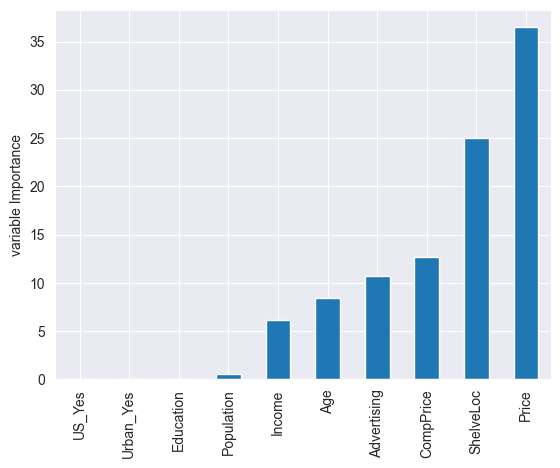

In [87]:
#BOOSTING
boosting_model = BC(n_estimators=20, random_state=6, learning_rate=0.1, max_depth=3)
y_predict= boosting_model.fit(x_train, y_train).predict(x_test)
acc = accuracy_score(y_test, y_predict)
print("Predict accuracy", acc)
feature_importance_boosting = boosting_model.feature_importances_ *100
feature_boosting =pd.Series(feature_importance_boosting, index=x.columns).sort_values()
print(feature_boosting)
feature_boosting.T.plot(kind="bar")
plt.ylabel("variable Importance")
plt.show()



#TODO
1.Investigate why more estimators causes error in bagging to reduce
2.